# 개선된 웹 검색 기반 주식 투자 챗봇
## 주요 개선사항:
- LLM 모델명 수정 (gpt-4o-mini)
- 평가 로직 수정 (낮은 점수일 때 웹 검색)
- Context 누적 로직
- 구조화된 출력
- 무한 루프 방지
- 에러 처리

In [1]:
# 환경 변수 로드
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# LLM 초기화 (수정: gpt-4o-mini로 변경)
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
# State 정의 (개선: 메타데이터 추가)
from typing_extensions import TypedDict
from typing import List, Dict, Any
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str                    # 사용자 질문
    context: List[Dict[str, Any]] # 웹 검색 결과 누적 리스트
    answer: str                   # 생성된 답변
    search_threshold: int         # 웹 검색 트리거 기준 점수 (이하면 검색)
    iteration_count: int          # 현재 반복 횟수
    max_iterations: int           # 최대 반복 횟수
    evaluation_score: int         # 마지막 평가 점수
    evaluation_comment: str       # 평가 코멘트
    error: str                    # 에러 메시지


graph_builder = StateGraph(AgentState)

In [4]:
# Generate 노드 (개선: 구조화된 출력, 에러 처리)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field


class AnswerOutput(BaseModel):
    """구조화된 답변 출력"""
    answer: str = Field(description="사용자 질문에 대한 상세한 답변")
    confidence: str = Field(description="답변 신뢰도: high/medium/low")
    sources_used: bool = Field(description="웹 검색 결과를 사용했는지 여부")


# Context가 있을 때 사용하는 프롬프트
context_prompt = PromptTemplate.from_template("""
당신은 주식 투자 전문가입니다. 주어진 웹 검색 자료(context)에 기반하여 질문(question)에 대한 답을 제공하세요.

검색 자료:
{context}

질문: {query}

답변 작성 지침:
1. 검색 자료의 정보를 정확히 인용하세요
2. 구체적인 수치와 날짜를 포함하세요
3. 출처가 명확하지 않은 추측은 피하세요
4. 간결하고 명확하게 작성하세요
""")

# Context가 없을 때 사용하는 프롬프트
simple_prompt = PromptTemplate.from_template("""
당신은 주식 투자 전문가입니다. 다음 질문에 답변하세요.

질문: {query}

답변 작성 지침:
1. 일반적인 투자 원칙과 지식을 바탕으로 답변하세요
2. 실시간 데이터가 필요한 경우 그 점을 명시하세요
3. 간결하고 명확하게 작성하세요
""")


def generate(state: AgentState) -> AgentState:
    """
    답변을 생성하는 노드
    - Context가 있으면 이를 활용하여 답변 생성
    - Context가 없으면 일반 지식으로 답변
    - 에러 발생 시 에러 메시지 저장
    """
    try:
        query = state["query"]
        context = state.get("context", [])
        iteration = state.get("iteration_count", 0)
        
        print(f"\n{'='*50}")
        print(f"[Generate] Iteration {iteration + 1}")
        print(f"Context 개수: {len(context)}")
        
        if context and len(context) > 0:
            # Context를 보기 좋게 포맷팅
            formatted_context = "\n\n".join([
                f"[출처 {i+1}]\n제목: {item.get('title', 'N/A')}\n내용: {item.get('content', item.get('raw_content', 'N/A')[:500])}\nURL: {item.get('url', 'N/A')}"
                for i, item in enumerate(context)
            ])
            
            chain = context_prompt | llm | StrOutputParser()
            response = chain.invoke({"context": formatted_context, "query": query})
            return {
                "answer": response,
                "iteration_count": iteration + 1
            }
        else:
            chain = simple_prompt | llm | StrOutputParser()
            response = chain.invoke({"query": query})
            return {
                "answer": response,
                "iteration_count": iteration + 1
            }
            
    except Exception as e:
        error_msg = f"Generate 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        return {
            "error": error_msg,
            "answer": "답변 생성 중 오류가 발생했습니다."
        }

In [5]:
# QA 평가 노드 (개선: 로직 수정 - 낮은 점수일 때 검색)
from typing import Literal


class EvaledAnswer(BaseModel):
    """답변 평가 결과"""
    score: int = Field(..., ge=0, le=20, description="각 기준별 점수를 합한 합산 점수 (0-20)")
    comment: str = Field(description="평가기준에 따른 상세 코멘트")
    needs_more_info: bool = Field(description="더 많은 정보가 필요한지 여부")


qa_eval_prompt = PromptTemplate(
    input_variables=["question", "answer"],
    template="""
다음 질문과 답변을 평가해주세요:

질문: {question}
답변: {answer}

평가 기준 (각 0-5점, 총 20점):
1. 정확성 (0-5점): 답변이 질문에 정확히 답하고 있는가?
2. 완전성 (0-5점): 답변이 충분히 상세하고 완전한가?
3. 명확성 (0-5점): 답변이 이해하기 쉽고 명확한가?
4. 관련성 (0-5점): 답변이 질문과 관련이 있는가?

평가 시 고려사항:
- 구체적인 수치, 날짜, 출처가 포함되어 있는가?
- "인터넷 검색이 필요하다", "확인할 수 없다" 등의 답변은 낮은 점수
- 실시간 주가, 최신 뉴스 등이 필요한 경우 needs_more_info를 true로 설정

각 기준에 대해 점수를 매기고, 평가 기준별 점수를 모두 더한 합산 점수(0-20)와 개선사항을 제시하세요.
"""  
)

structured_qa_eval_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(EvaledAnswer)


def qa_eval(state: AgentState) -> Literal['enough', 'search', 'max_reached']:
    """
    답변 품질을 평가하는 노드
    
    로직 개선:
    - 점수가 threshold 이상이면 'enough' (종료)
    - 점수가 threshold 미만이면 'search' (웹 검색)
    - max_iterations 도달하면 'max_reached' (강제 종료)
    """
    try:
        answer = state["answer"]
        query = state["query"]
        iteration = state.get("iteration_count", 0)
        search_threshold = state.get("search_threshold", 15)
        max_iterations = state.get("max_iterations", 3)
        
        # 에러가 있으면 즉시 종료
        if state.get("error"):
            return 'max_reached'
        
        eval_chain = qa_eval_prompt | structured_qa_eval_llm
        response = eval_chain.invoke({"answer": answer, "question": query})
        
        score = response.score
        comment = response.comment
        needs_more_info = response.needs_more_info
        
        print(f"\n[QA Eval] Iteration {iteration}")
        print(f"평가 점수: {score}/20")
        print(f"코멘트: {comment}")
        print(f"추가 정보 필요: {needs_more_info}")
        
        # State 업데이트
        state["evaluation_score"] = score
        state["evaluation_comment"] = comment
        
        # 최대 반복 횟수 도달 체크
        if iteration >= max_iterations:
            print(f"⚠️ 최대 반복 횟수({max_iterations}) 도달. 종료합니다.")
            return 'max_reached'
        
        # 점수가 threshold 이상이고 추가 정보 불필요하면 종료
        if score >= search_threshold and not needs_more_info:
            print(f"✅ 점수가 threshold({search_threshold}) 이상입니다. 종료합니다.")
            return 'enough'
        
        # 점수가 낮거나 추가 정보 필요하면 웹 검색
        print(f"🔍 점수가 낮거나 추가 정보가 필요합니다. 웹 검색을 실행합니다.")
        return 'search'
        
    except Exception as e:
        error_msg = f"QA Eval 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        state["error"] = error_msg
        return 'max_reached'

In [6]:
# Web Search 노드 (개선: Context 누적, 에러 처리)
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False  # 이미지는 제외하여 토큰 절약
)


def web_search(state: AgentState) -> AgentState:
    """
    웹 검색을 수행하는 노드
    
    개선:
    - Context를 누적하여 저장 (덮어쓰기 X)
    - 중복 URL 제거
    - 에러 처리
    """
    try:
        query = state["query"]
        existing_context = state.get("context", [])
        iteration = state.get("iteration_count", 0)
        
        print(f"\n[Web Search] 검색 쿼리: {query}")
        
        # 웹 검색 실행
        results = tavily_search_tool.invoke(query)
        
        if not results:
            print("⚠️ 검색 결과가 없습니다.")
            return {"error": "검색 결과가 없습니다."}
        
        print(f"✅ 검색 결과 {len(results)}개 발견")
        
        # 기존 URL 추출
        existing_urls = {item.get('url') for item in existing_context if item.get('url')}
        
        # 새로운 결과만 추가 (중복 제거)
        new_results = [
            result for result in results 
            if result.get('url') not in existing_urls
        ]
        
        # Context 누적
        updated_context = existing_context + new_results
        
        print(f"새로운 검색 결과: {len(new_results)}개")
        print(f"총 Context: {len(updated_context)}개")
        
        # 출처 출력
        for i, result in enumerate(new_results):
            print(f"  [{i+1}] {result.get('title', 'N/A')[:50]}...")
            print(f"      {result.get('url', 'N/A')}")
        
        return {"context": updated_context}
        
    except Exception as e:
        error_msg = f"Web Search 함수 에러: {str(e)}"
        print(f"❌ {error_msg}")
        return {"error": error_msg}

/var/folders/13/7wddtg0s5lzd71y5ldrbyf2m0000gn/T/ipykernel_42609/3044733361.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [7]:
# 그래프 구성
from langgraph.graph import START, END

# 노드 추가
graph_builder.add_node("generate", generate)
graph_builder.add_node("web_search", web_search)

# 엣지 추가
graph_builder.add_edge(START, "generate")

# 조건부 엣지: generate → qa_eval → enough/search/max_reached
graph_builder.add_conditional_edges(
    'generate',
    qa_eval,
    {
        'enough': END,           # 충분한 답변 → 종료
        'search': 'web_search',  # 검색 필요 → 웹 검색
        'max_reached': END       # 최대 반복 도달 → 종료
    }
)

# 웹 검색 → 다시 답변 생성
graph_builder.add_edge("web_search", "generate")

# 그래프 컴파일
graph = graph_builder.compile()

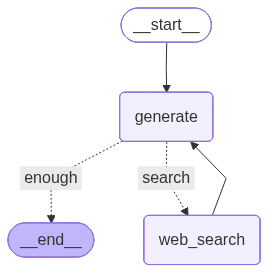

In [8]:
# 그래프 시각화
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화 실패: {e}")
    print("텍스트로 그래프 구조 출력:")
    print("START → generate → [qa_eval]")
    print("  ├─ enough → END")
    print("  ├─ search → web_search → generate")
    print("  └─ max_reached → END")

In [9]:
# 실행 테스트
from pprint import pprint

initial_state = {
    'query': '2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘',
    'search_threshold': 15,      # 15점 이상이면 충분
    'iteration_count': 0,
    'max_iterations': 3,         # 최대 3번 반복
    'context': [],
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print("="*70)
print("주식 투자 챗봇 - 웹 검색 기반 답변 생성")
print("="*70)
print(f"질문: {initial_state['query']}")
print(f"검색 threshold: {initial_state['search_threshold']}점")
print(f"최대 반복: {initial_state['max_iterations']}회")
print("="*70)

# 스트림 모드로 실행
for update in graph.stream(initial_state, stream_mode="updates"):
    pass  # 각 노드의 print문으로 진행상황 출력

# 최종 결과 실행
final_result = graph.invoke(initial_state)

print("\n" + "="*70)
print("최종 결과")
print("="*70)
print(f"\n총 반복 횟수: {final_result.get('iteration_count', 0)}")
print(f"최종 평가 점수: {final_result.get('evaluation_score', 0)}/20")
print(f"평가 코멘트: {final_result.get('evaluation_comment', 'N/A')}")
print(f"사용된 검색 결과: {len(final_result.get('context', []))}개")
if final_result.get('error'):
    print(f"❌ 에러: {final_result['error']}")

print(f"\n{'='*70}")
print("최종 답변:")
print("="*70)
print(final_result.get('answer', 'N/A'))
print("="*70)

주식 투자 챗봇 - 웹 검색 기반 답변 생성
질문: 2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘
검색 threshold: 15점
최대 반복: 3회

[Generate] Iteration 1
Context 개수: 0

[QA Eval] Iteration 1
평가 점수: 12/20
코멘트: 답변은 질문에 대한 실시간 데이터 제공이 불가능하다는 점을 명확히 하고 있으며, 삼성전자의 시장 위치와 주가에 영향을 미치는 요소들에 대한 일반적인 설명을 포함하고 있습니다. 그러나 구체적인 수치나 날짜가 없고, 질문에 대한 직접적인 답변이 부족하여 점수가 낮습니다. 또한, 실시간 주가 정보가 필요하다는 점을 명시했으므로 needs_more_info를 true로 설정하는 것이 적절합니다.
추가 정보 필요: True
🔍 점수가 낮거나 추가 정보가 필요합니다. 웹 검색을 실행합니다.

[Web Search] 검색 쿼리: 2025년 10월 삼성전자 주식의 현재 주가와 최근 동향을 알려줘
✅ 검색 결과 3개 발견
새로운 검색 결과: 3개
총 Context: 3개
  [1] 삼성전자 (005930) - 인베스팅닷컴...
      https://kr.investing.com/equities/samsung-electronics-co-ltd
  [2] 삼성전자 주가 - 실시간 차트 및 종목정보 - 알파스퀘어...
      https://alphasquare.co.kr/home/stock-summary?code=005930
  [3] 삼성 전자 주가 전망: 2025년, 2026년 - 경제 예측 기관...
      https://wonforecast.com/samsung-electronics

[Generate] Iteration 2
Context 개수: 3

[QA Eval] Iteration 2
평가 점수: 15/20
코멘트: 답변은 질문에 대한 주가 정보와 최근 동향을 제공하고 있으며, 삼성전자의 사업 전략에 대한 추가 정보도 포함되어 있어 유용합니다. 그러나 2

In [ ]:
# 웹 검색 없이도 답변 가능한 질문 테스트
simple_state = {
    'query': '주식 투자 시 분산 투자의 중요성에 대해 설명해줘',
    'search_threshold': 15,
    'iteration_count': 0,
    'max_iterations': 3,
    'context': [],
    'answer': '',
    'evaluation_score': 0,
    'evaluation_comment': '',
    'error': ''
}

print("\n" + "="*70)
print("일반 투자 지식 질문 테스트 (웹 검색 불필요)")
print("="*70)

simple_result = graph.invoke(simple_state)

print(f"\n최종 평가 점수: {simple_result.get('evaluation_score', 0)}/20")
print(f"반복 횟수: {simple_result.get('iteration_count', 0)}")
print(f"\n답변:\n{simple_result.get('answer', 'N/A')}")